<a href="https://colab.research.google.com/github/vernicabeohar/sunspot-prediction-time-series-analysis/blob/main/Sunspot_Prediction_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os 
#os.chdir('D:/')
import warnings
warnings.filterwarnings('ignore')
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

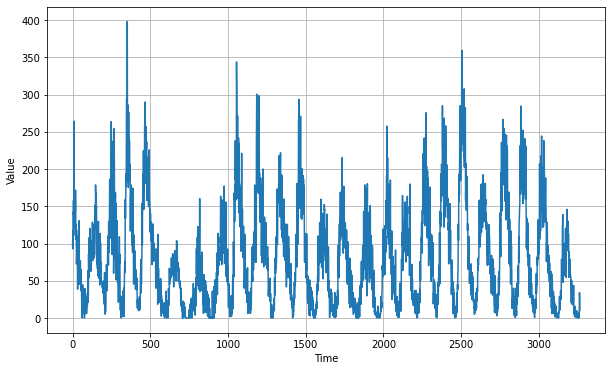

In [5]:
import csv
time_step = []
sunspots = []

with open('Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)


In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8)#, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/100
12/12 [==============================] - 10s 315ms/step - loss: 80.0785 - mae: 80.5759 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 4s 311ms/step - loss: 79.8190 - mae: 80.3164 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 4s 330ms/step - loss: 79.5268 - mae: 80.0241 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 5s 377ms/step - loss: 79.1979 - mae: 79.6952 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 4s 314ms/step - loss: 78.8154 - mae: 79.3127 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 4s 311ms/step - loss: 78.3808 - mae: 78.8781 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 4s 314ms/step - loss: 77.8864 - mae: 78.3839 - lr: 1.9953e-08
Epoch 8/100
12/12 [=======

(1e-08, 0.0001, 0.0, 60.0)

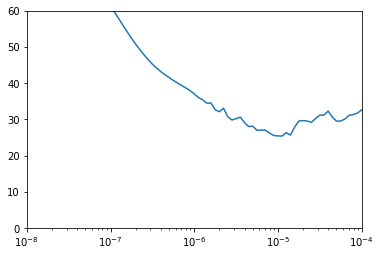

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 121ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 4s 119ms/step - loss: 25.7649 - mae: 26.2594
Epoch 3/500
30/30 [==============================] - 4s 119ms/step - loss: 22.0802 - mae: 22.5739
Epoch 4/500
30/30 [==============================] - 4s 118ms/step - loss: 20.4667 - mae: 20.9596
Epoch 5/500
30/30 [==============================] - 4s 118ms/step - loss: 19.7063 - mae: 20.1988
Epoch 6/500
30/30 [==============================] - 4s 119ms/step - loss: 19.3125 - mae: 19.8046
Epoch 7/500
30/30 [==============================] - 4s 118ms/step - loss: 18.7651 - mae: 19.2574
Epoch 8/500
30/30 [==============================] - 4s 119ms/step - loss: 18.1174 - mae: 18.6090
Epoch 9/500
30/30 [==============================] - 4s 120ms/step - loss: 18.0741 - mae: 18.5657
Epoch 10/500
30/30 [==============================] - 4s 119ms/step - loss: 17.8847 - mae: 18.3758
Epoch 11/500
30/30 

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

101/101 [==============================] - 4s 22ms/step


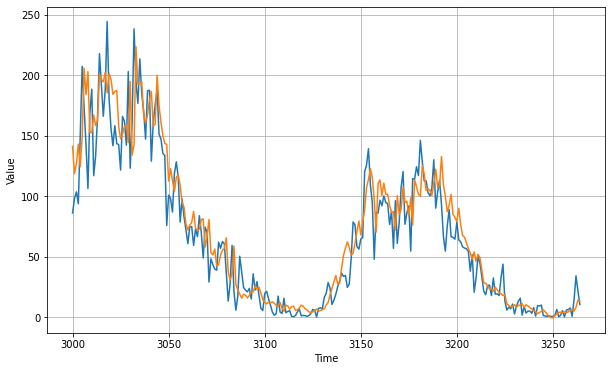

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.795101